In [1]:
import requests
from pandas import Timestamp as ts
import scipy as sp
import scipy.stats as ss
import statsmodels as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import time
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from urllib.parse import urlencode 
from operator import attrgetter
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu

PATH_REGISRATION_DATA = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-kachanovskij-24/shared/problem1-reg_data.csv' #Дата регистрации
PATH_AUTH_DATA = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-kachanovskij-24/shared/problem1-auth_data.csv' # Данные о времени захода пользователей в игру

PATH_LESS_02 = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'

less1_reg_data_df = pd.read_csv(PATH_REGISRATION_DATA,sep=';')
less1_auth_data_df = pd.read_csv(PATH_AUTH_DATA, sep=';')

In [2]:
less1_reg_data_df

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [3]:
less1_auth_data_df

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [4]:
# Данные нужно преобразовать в формат Timestemp
less1_reg_data_df.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
# Данные нужно преобразовать в формат Timestemp
less1_auth_data_df.dtypes

auth_ts    int64
uid        int64
dtype: object

In [6]:
less1_reg_data_df.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [7]:
less1_auth_data_df.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [8]:
less1_auth_data_df.drop_duplicates() # Проверил на наличие дубликатов

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


----

## Подготовка главного датафрейма

In [9]:
all_date_df = less1_auth_data_df.merge(less1_reg_data_df, how='right', on='uid')

In [10]:
all_date_df

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089
...,...,...,...
9601008,1600874034,1110618,1600874034
9601009,1600874086,1110619,1600874086
9601010,1600874139,1110620,1600874139
9601011,1600874191,1110621,1600874191


In [11]:
all_date_datetime_df = all_date_df
all_date_datetime_df['auth_ts'] = (all_date_datetime_df['auth_ts'].apply(dt.fromtimestamp)).dt.date
all_date_datetime_df['reg_ts'] = (all_date_datetime_df['reg_ts'].apply(dt.fromtimestamp)).dt.date
all_date_datetime_df['auth_ts'] = pd.to_datetime(all_date_datetime_df['auth_ts'])
all_date_datetime_df['reg_ts'] = pd.to_datetime(all_date_datetime_df['reg_ts'])
all_date_datetime_df = all_date_datetime_df[['uid', 'reg_ts', 'auth_ts']]
all_date_datetime_df

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-23,1999-07-23
2,2,1999-07-23,1999-07-25
3,2,1999-07-23,1999-07-31
4,2,1999-07-23,1999-08-05
...,...,...,...
9601008,1110618,2020-09-23,2020-09-23
9601009,1110619,2020-09-23,2020-09-23
9601010,1110620,2020-09-23,2020-09-23
9601011,1110621,2020-09-23,2020-09-23


In [12]:
all_date_datetime_df.nunique()# проверка корректности

uid        1000000
reg_ts        5110
auth_ts       6171
dtype: int64

---

# Задание 1
#### В первую очередь, нас интересует показатель retention. Написать функцию для его подсчета.

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:



In [13]:
all_date_datetime_df

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-23,1999-07-23
2,2,1999-07-23,1999-07-25
3,2,1999-07-23,1999-07-31
4,2,1999-07-23,1999-08-05
...,...,...,...
9601008,1110618,2020-09-23,2020-09-23
9601009,1110619,2020-09-23,2020-09-23
9601010,1110620,2020-09-23,2020-09-23
9601011,1110621,2020-09-23,2020-09-23


---

In [14]:
def retention_rate (cohort_all_df, left_border, right_border, units="M", cmap="Blues", out_format="{:.2}"):    
    if (units == "M"):
        tmp_tmp_df = cohort_all_df.query("reg_ts >= @left_border and reg_ts <= @right_border and auth_ts <= @right_border").copy()
    
        tmp_tmp_df['cohort'] = tmp_tmp_df.reg_ts.dt.to_period('M')
        tmp_tmp_df.reg_ts = tmp_tmp_df.reg_ts.dt.to_period('M')
        tmp_tmp_df.auth_ts = tmp_tmp_df.auth_ts.dt.to_period('M')

        cohorts_df = tmp_tmp_df.groupby(['cohort', 'auth_ts'])\
            .agg({'uid': 'nunique'})\
            .rename(columns=({'uid':'unique_users'}))\
            .reset_index()

        cohorts_df['Month:'] = (cohorts_df.auth_ts - cohorts_df.cohort).apply(attrgetter('n'))
        retention_pivot = cohorts_df.pivot_table(index='cohort', columns='Month:', values='unique_users')
        cohort_size = retention_pivot.iloc[:,0]
        retention = retention_pivot.divide(cohort_size, axis = 0)

        final_retention = (retention.style.background_gradient(cmap=cmap).highlight_null('white').format(out_format, na_rep=""))
    
    elif (units == "D"):
        tmp_tmp_df = cohort_all_df.query("reg_ts >= @left_border and reg_ts <= @right_border and auth_ts <= @right_border").copy()
        
        tmp_tmp_df['cohort'] = tmp_tmp_df.reg_ts
    
        cohorts_df = tmp_tmp_df.groupby(['cohort', 'auth_ts'])\
            .agg({'uid': 'nunique'})\
            .rename(columns=({'uid':'unique_users'}))\
            .reset_index()

        cohorts_df['Days:'] = (cohorts_df.auth_ts - cohorts_df.cohort).dt.days+1
        cohorts_df['cohort'] = cohorts_df['cohort'].dt.date
        # строю retention матрицу
        retention_pivot = cohorts_df.pivot_table(index='cohort', columns='Days:', values='unique_users')
        cohort_size = retention_pivot.iloc[:,0]
        retention = retention_pivot.divide(cohort_size, axis = 0)
        
        final_retention = (retention.style.background_gradient(cmap=cmap).highlight_null('white').format(out_format, na_rep=""))
    elif (units == "Y"):
        tmp_tmp_df = cohort_all_df.query("reg_ts >= @left_border and reg_ts <= @right_border and auth_ts <= @right_border").copy()
    
        tmp_tmp_df['cohort'] = tmp_tmp_df.reg_ts.dt.to_period('Y')
        tmp_tmp_df.reg_ts = tmp_tmp_df.reg_ts.dt.to_period('Y')
        tmp_tmp_df.auth_ts = tmp_tmp_df.auth_ts.dt.to_period('Y')

        cohorts_df = tmp_tmp_df.groupby(['cohort', 'auth_ts'])\
                .agg({'uid': 'nunique'})\
                .rename(columns=({'uid':'unique_users'}))\
                .reset_index()

        cohorts_df['Years:'] = (cohorts_df.auth_ts - cohorts_df.cohort).apply(attrgetter('n'))
        retention_pivot = cohorts_df.pivot_table(index='cohort', columns='Years:', values='unique_users')
        cohort_size = retention_pivot.iloc[:,0]
        retention = retention_pivot.divide(cohort_size, axis = 0)

        final_retention = (retention.style.background_gradient(cmap=cmap).highlight_null('white').format(out_format, na_rep=""))
    return final_retention

**Описание функции:**

Ярешил написать универсальную функцию, которую можно будет использовать в дальнейшем с другими единицами измерений

- cohort_all_df - исходный датафрейм
- left_border - дата начала временного промежутка
- right_border - дата окончания временного помежутка
- units - Единицы по которым считается retention (Год, Месяц, День - Y, M или D)
- cmap - Цветовая политра отображения графиков
- out_format - формат вывода результата (Доли или проценты)

----

#### Тесты:

In [15]:
retention_rate(all_date_datetime_df,"2019-09-01","2019-09-30", "D", "Oranges")

Days:,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-01,1.0,0.018,0.043,0.04,0.048,0.076,0.071,0.07,0.047,0.06,0.059,0.06,0.051,0.062,0.053,0.046,0.053,0.056,0.051,0.047,0.041,0.043,0.032,0.039,0.051,0.047,0.035,0.039,0.03,0.037
2019-09-02,1.0,0.022,0.029,0.041,0.046,0.067,0.055,0.046,0.049,0.062,0.041,0.059,0.04,0.052,0.032,0.049,0.057,0.046,0.038,0.039,0.045,0.038,0.048,0.031,0.034,0.032,0.036,0.03,0.032,
2019-09-03,1.0,0.023,0.036,0.052,0.052,0.065,0.078,0.057,0.04,0.064,0.047,0.069,0.049,0.039,0.048,0.046,0.051,0.051,0.037,0.047,0.045,0.036,0.038,0.037,0.033,0.038,0.032,0.033,,
2019-09-04,1.0,0.01,0.039,0.046,0.05,0.054,0.073,0.061,0.05,0.045,0.057,0.04,0.045,0.057,0.049,0.044,0.052,0.042,0.03,0.044,0.047,0.04,0.041,0.031,0.024,0.032,0.031,,,
2019-09-05,1.0,0.017,0.041,0.046,0.048,0.064,0.078,0.061,0.045,0.056,0.037,0.049,0.053,0.05,0.049,0.031,0.043,0.049,0.034,0.049,0.031,0.038,0.035,0.049,0.03,0.032,,,,
2019-09-06,1.0,0.018,0.04,0.043,0.045,0.04,0.074,0.058,0.05,0.046,0.047,0.054,0.038,0.058,0.043,0.045,0.049,0.045,0.043,0.033,0.041,0.033,0.025,0.032,0.038,,,,,
2019-09-07,1.0,0.025,0.046,0.047,0.056,0.048,0.084,0.064,0.051,0.051,0.05,0.057,0.05,0.042,0.043,0.043,0.047,0.042,0.046,0.032,0.034,0.03,0.041,0.034,,,,,,
2019-09-08,1.0,0.015,0.035,0.04,0.06,0.051,0.064,0.064,0.048,0.051,0.043,0.052,0.061,0.042,0.042,0.044,0.051,0.035,0.046,0.046,0.053,0.035,0.038,,,,,,,
2019-09-09,1.0,0.025,0.036,0.051,0.047,0.068,0.074,0.041,0.056,0.05,0.066,0.049,0.061,0.047,0.047,0.049,0.053,0.047,0.04,0.052,0.048,0.036,,,,,,,,


In [16]:
retention_rate(all_date_datetime_df,"2018-01-01", "2020-01-01")

Month:,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
cohort,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01,1.0,0.17,0.065,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.012
2018-02,1.0,0.18,0.062,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.013,
2018-03,1.0,0.18,0.064,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.013,,
2018-04,1.0,0.18,0.064,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.053,0.015,,,
2018-05,1.0,0.17,0.064,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.013,,,,
2018-06,1.0,0.18,0.064,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.014,,,,,
2018-07,1.0,0.17,0.059,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.011,,,,,,
2018-08,1.0,0.17,0.062,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.049,0.011,,,,,,,
2018-09,1.0,0.17,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.012,,,,,,,,


In [17]:
retention_rate(all_date_datetime_df,"2010-01-01", "2020-07-01", "Y", "Greens", "{:.1%}")

Years:,0,1,2,3,4,5,6,7,8,9,10
cohort,,,,,,,,,,,
2010,100.0%,6.4%,4.1%,4.1%,4.1%,4.1%,4.1%,4.1%,4.1%,4.1%,4.1%
2011,100.0%,6.8%,5.2%,5.2%,5.2%,5.2%,5.2%,5.2%,5.2%,5.2%,
2012,100.0%,6.4%,5.0%,5.0%,5.0%,5.0%,5.0%,5.0%,5.0%,,
2013,100.0%,6.5%,4.9%,4.9%,4.9%,4.9%,4.9%,4.9%,,,
2014,100.0%,6.5%,5.2%,5.2%,5.2%,5.2%,5.2%,,,,
2015,100.0%,6.3%,4.9%,4.9%,4.9%,4.9%,,,,,
2016,100.0%,6.5%,5.0%,5.0%,5.0%,,,,,,
2017,100.0%,6.6%,5.0%,5.0%,,,,,,,
2018,100.0%,6.5%,5.0%,,,,,,,,


----

# Задание 2
#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [18]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = PATH_LESS_02
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
download_url = requests.get(final_url).json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
ab_less02_df = pd.read_csv(download_url, sep=';') 
ab_less02_df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [19]:
ab_less02_df.dtypes # Проверка типов колонок

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [20]:
ab_less02_df.nunique() # Можем увидеть, что все пользователи являются уникальными

user_id      404770
revenue        1477
testgroup         2
dtype: int64

---

_Здесь я решил сделать первичную оценку датафрейма и ознакомится с данными которые даны.
Последующий анализ задачи буду производить в Tableau для наглядности. Ссылку на финальный дашборд расположу ниже, а также в папку с проектом положу картинку с графиками, на основе которых я делал выводы._

#### Для граммотной оценки проведеных тестов я выбрал следующие метрики:

 - Gross - сумма платежей в каждой группе
 - Sales - кол-во покупок 
 - CR - конверсия в покупку
 - ARPU - сколько денег в среднем приносит один игрок
 - ARPPU - сколько денег в среднем приносит один платящий игрок (Средний чек нам не подойдет, т.к. все пользовател уникальные и не совершали повторные платежи)


---

In [21]:
# Добавляю колонку "pay_status", для удобства вычислений в Tableau:
ab_less02_df['pay_status'] = np.where((ab_less02_df.revenue > 0), 1, 0)
ab_less02_df.to_csv('less_02_tmp.csv', encoding='utf-8', index=False)

In [22]:
ab_less02_df

,user_id,revenue,testgroup,pay_status
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [23]:
ab_less02_df_payment = ab_less02_df.query('revenue > 0')
ab_less02_df_payment

,user_id,revenue,testgroup,pay_status
72,73,351,a,1
160,161,3797,b,1
341,342,290,a,1
377,378,3768,b,1
385,386,250,a,1
...,...,...,...,...
404315,404316,262,a,1
404525,404526,3120,b,1
404543,404544,369,a,1
404602,404603,251,a,1


In [24]:
# кол-во платящих:
count_rev = ab_less02_df.query('revenue > 0').count()[0]
count_rev_a = ab_less02_df.query("revenue > 0 and testgroup == 'a'").count()[0]
count_rev_b = ab_less02_df.query("revenue > 0 and testgroup == 'b'").count()[0]

# Gross
gross = ab_less02_df.groupby('testgroup').agg({'revenue':'sum'})
gross_a = ab_less02_df.groupby('testgroup').agg({'revenue':'sum'}).query("testgroup == 'a'").revenue[0]
gross_b = ab_less02_df.groupby('testgroup').agg({'revenue':'sum'}).query("testgroup == 'b'").revenue[0]

# Sales
sales = ab_less02_df.query('revenue > 0').groupby('testgroup').agg({'revenue':'count'})
sales_a = ab_less02_df.query('revenue > 0').groupby('testgroup').agg({'revenue':'count'}).query("testgroup == 'a'").revenue[0]
sales_b = ab_less02_df.query('revenue > 0').groupby('testgroup').agg({'revenue':'count'}).query("testgroup == 'b'").revenue[0]
sales_proc_div = (100 - ((sales.revenue[1] * 100) / sales.revenue[0])).round(2)

# CR
cr = ((sales/ab_less02_df.groupby('testgroup').agg({'revenue':'count'})) * 100).round(2)
cr_a = ((sales/ab_less02_df.groupby('testgroup').agg({'revenue':'count'})) * 100).round(2).query("testgroup == 'a'").revenue[0]
cr_b = ((sales/ab_less02_df.groupby('testgroup').agg({'revenue':'count'})) * 100).round(2).query("testgroup == 'b'").revenue[0]

# ARPU
ARPU = (gross.revenue / ab_less02_df.groupby('testgroup').agg({'user_id':'count'}).user_id).round(2)
ARPU_a = (gross.revenue / ab_less02_df.groupby('testgroup').agg({'user_id':'count'}).user_id).round(2)[0]
ARPU_b = (gross.revenue / ab_less02_df.groupby('testgroup').agg({'user_id':'count'}).user_id).round(2)[1]

# Проверил разницу ARPU у двух групп
ARPU_div = 100 - ((ARPU[0] * 100) / ARPU[1]) 

# ARPPU
ARPPU = (gross.revenue / ab_less02_df.query('revenue > 0').groupby('testgroup').agg({'user_id':'count'}).user_id).round(2)
ARPPU_a = (gross.revenue / ab_less02_df.query('revenue > 0').groupby('testgroup').agg({'user_id':'count'}).user_id).round(2)[0]
ARPPU_b = (gross.revenue / ab_less02_df.query('revenue > 0').groupby('testgroup').agg({'user_id':'count'}).user_id).round(2)[1]

# Проверил разницу ARPPU у двух групп
ARPPU_div = 100 - ((ARPPU[0] * 100) / ARPPU[1])

In [25]:
# Получим:
print('')
print('Кол-во платящих пользователей: {0}'.format(count_rev))
print('')
print('Gross:')
print('Сумма платежей в каждой группе a: {0}'.format(gross_a))
print('Сумма платежей в каждой группе b: {0}'.format(gross_b))
print('')
print('Sales:')
print('Кол-во покупок в группе a: {0}'.format(sales_a))
print('Кол-во покупок в группе b: {0}'.format(sales_b))
print('Разница: {0}'.format(sales_proc_div))
print('')
print('CR:')
print('Конверсия в покупку в группе a: {0}'.format(cr_a))
print('Конверсия в покупку в группе b: {0}'.format(cr_b))
print('')
print('ARPU:')
print('Cколько денег в среднем приносит один игрок в группе a: {0}'.format(ARPU_a))
print('Cколько денег в среднем приносит один игрок в группе b: {0}'.format(ARPU_b))
print('Разница: {0}'.format(ARPU_div))
print('')
print('ARPPU:')
print('Cколько денег в среднем приносит один платящий игрок в группе a: {0}'.format(ARPPU_a))
print('Cколько денег в среднем приносит один платящий игрок в группе b: {0}'.format(ARPPU_b))
print('Разница: {0}'.format(ARPPU_div))
print('')


Кол-во платящих пользователей: 3733

Gross:
Сумма платежей в каждой группе a: 5136189
Сумма платежей в каждой группе b: 5421603

Sales:
Кол-во покупок в группе a: 1928
Кол-во покупок в группе b: 1805
Разница: 6.38

CR:
Конверсия в покупку в группе a: 0.95
Конверсия в покупку в группе b: 0.89

ARPU:
Cколько денег в среднем приносит один игрок в группе a: 25.41
Cколько денег в среднем приносит один игрок в группе b: 26.75
Разница: 5.00934579439253

ARPPU:
Cколько денег в среднем приносит один платящий игрок в группе a: 2664.0
Cколько денег в среднем приносит один платящий игрок в группе b: 3003.66
Разница: 11.30820399113081



In [26]:
# проверяю различия в конверсии:

# H0 - в конверсии групп нет статистически значимых различий
# H1 - в конверсии групп есть статистически значимые различия

ss.chi2_contingency(pd.crosstab(ab_less02_df.revenue > 0, ab_less02_df.testgroup))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

**Т.к. p-value < 0.05, значит мы можем отклонить гипотезу H0, следовательно в конверсии групп есть статистически значимые отличия**

In [27]:
# проверка на нормальность растпределения:
ss.normaltest(ab_less02_df['revenue'])

NormaltestResult(statistic=1270274.6942053374, pvalue=0.0)

**Т.к. распределение не нормальное, значит t-test нам не подходит**

In [28]:
ab_less02_df_payment.groupby('revenue', as_index = False) \
    .agg({'revenue':'count'}) \
    .sort_values('revenue',ascending = False)

,revenue
6,18
110,18
24,17
65,17
197,17
...,...
726,1
727,1
729,1
730,1


**Видно, что у нас есть повторяющиеся значения, значит U–тест Манна-Уитни нам не подойдет**

In [29]:
# буду использовать Bootstrap 

plt.style.use('ggplot')

# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

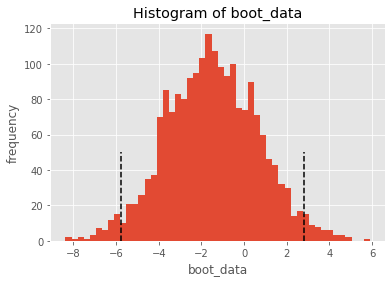

In [30]:
# ARPU
booted= get_bootstrap(ab_less02_df.query("testgroup == 'a'").revenue,
                          ab_less02_df.query("testgroup == 'b'").revenue),

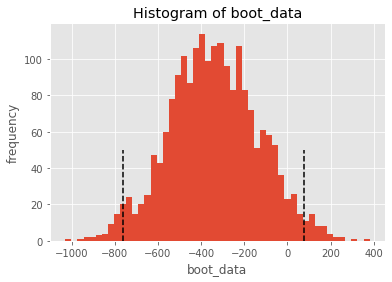

In [31]:
# ARPPU
booted_payment = get_bootstrap(ab_less02_df.query("testgroup == 'a' and revenue > 0").revenue,
                          ab_less02_df.query("testgroup == 'b' and revenue > 0").revenue),

In [32]:
# ARPU

# H0 - в ARPU групп нет статистически значимых различий
# H1 - в ARPU групп есть статистически значимые различия

booted

({'ci':               0
  0.025 -5.758466
  0.975  2.809862,
  'p_value': 0.4886487870155255},)

**Т.к. p-value > 0.05, значит мы не можем отклонить гипотезу H0, следовательно в ARPU групп нет статистически значимых различий**

In [33]:
# ARPPU

# H0 - в ARPPU групп нет статистически значимых различий
# H1 - в ARPPU групп есть статистически значимые различия

booted_payment

({'ci':                 0
  0.025 -759.759116
  0.975   76.044074,
  'p_value': 0.10183679940120922},)

**Т.к. p-value > 0.05, значит мы не можем отклонить гипотезу H0, следовательно в ARPPU групп нет статистически значимых различий**

In [34]:
# Анализ заплативших:

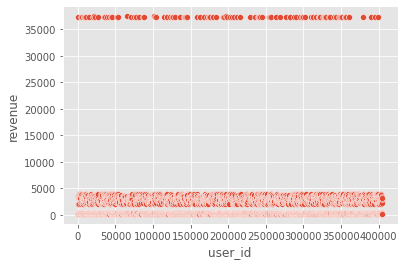

In [35]:
sns.scatterplot(x="user_id",
                    y="revenue",
                    data=ab_less02_df_payment)

In [36]:
# Видны выбросы
ab_less02_df_payment_max = ab_less02_df_payment.query('revenue > 5000').sort_values('revenue', ascending = False)
ab_less02_df_payment_max

,user_id,revenue,testgroup,pay_status
101861,101862,37433,a,1
196601,196602,37407,a,1
65077,65078,37394,a,1
21585,21586,37385,a,1
142804,142805,37379,a,1
...,...,...,...,...
81477,81478,37294,a,1
254113,254114,37294,a,1
34534,34535,37294,a,1
235858,235859,37294,a,1


In [37]:
# Видно, что аномальные суммы в группе А
ab_less02_df_payment_max.groupby('testgroup').agg({'user_id':'count'})

,user_id
testgroup,
a,123


In [38]:
# Выручка аномальными суммами в группе А
ab_less02_df_payment_max.groupby('testgroup').agg({'revenue':'sum'})

,revenue
testgroup,
a,4590252


---

**Ссылка на дашборд**

https://public.tableau.com/app/profile/.23998523/viz/FinalProject_16682158740300/FinalDashboard?publish=yes

---

### Проанализировав результаты проведенного A/B Тестирования, можно следелать вывод:

1) Суммарная прибыль в группе "В" выше на **285414**

2) Кол-во продаж наборов выше в группе "А" на **123** (6,38%)

3) Конверсия в покупку выше в группе "А", но незначительно (всего на 0,06 процента)

4) ARPU тестовой группы выше чем в контрольной на 5%, ARPPU же и вовсе - 11,3%

---

- Видно что, существенная разница только в конверсии

- Bootstrap ARPU - различия статистически не значимы
- Bootstrap ARPPU - различия статистически не значимы

- Проанализировав доход по группам, я увидел достаточное кол-во выбросов. Как оказалость, аномальные суммы были заплачены только в группе А. 

**_Заключение: Так как суммарная прибыль, ARPU и ARPPU выше в группе "B", а почти вся прибыль группы "А" построена на выбросах, рекомендуемо остановить свой выбор в пользу группы "B"_**

---

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?


**Ответ:**

 - _Total user_ и _Total visit_ - общее кол-во пользователей и визитов совершенное за событие
 - _RUR_ - Используя эту метрику можно понять на сколько данное событие повлияло на возвращаемость игроков в игру
 - _Кол-во пройденных уровней игрками_ - так можно оценить их сложность
 - _Кол-во полученых наград каждого вида_ - так можно проанализировать какие итемы пользуются большим спросом
 - Так же сложность уровней или желанность каких-либо предметов можно проанализировать по _увеличению транзакций_ (если они предусмотрены и в игре есть расходники втечение уровня для более легкого проходжения)
 - _ER_ - сколько игроков из активных используют режим
 - _DAU_ - дневная активность
 - _MAU_ - месячная активность
 - _AGR_ - можем отследить темп роста аудитории
 - _Кол-во установок приложения_ - отражение события на новых клентах
 - _Revenue Churn_ и _Churn rate_ - для отслеживания оттока пользователей
 - _Total Revenue_ - доход в период провдения подобных событий
 - _Кол-во часов проведенное пользователем в игре_ - можно оценить вовлеченность клиентов в данное событие
 - _Среднее время в игре и в игре во время события_ 
 - _Конверсия_ в пользователей, а позже в участников события.
 - _Отзывы_ и _голосования_, а также _заинтересованность_ в популярных пабликах и сервисах по игре
 
 
 
Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Ответ**

Добавятся следующие метрики:

 - _Частота повторного прохождения уровня после проигрыша_ - заинтересованность в награде или в уровне
 - _Кол-во попыток перепрохождения уровня за сессию_ - заинтересованность в награде
 - _Среднее смещение на кол-во уровней за прохождение события_ - оценка сложности уровней
 - _Кол-во дней до повторной попытки_ 
